In [15]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from numpy import conj,argmax
from scipy import signal

In [16]:
logFileName = 'delay'

In [17]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) 
#df.head()
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
#print(time[0])
time=time-time[0]
#print(time)
diffOfTime = np.diff(time)
#print(diffOfTime)
averageUs = np.median(diffOfTime)
#print(averageUs)
samplingRate = 1000000/averageUs
print(samplingRate)

2000.0


In [18]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]
#print(setpointData)
#print(gyroADCData)
#print(gyroScaleData)
print(thrData)

[1000 1000 1000 ... 1244 1244 1244]


In [19]:
def calculateDelay(a,b):
    
    a_fft    = fft(np.hamming(len(a)) *a)   #a must be later than b
    #a_fft    = fft(a)
    b_fft    = fft(np.hamming(len(b)) *b)   #hamming for now, maybe hanning is better?
    #b_fft    = fft(b)
    c       = ifft(a_fft*conj(b_fft))
    time_shift  = argmax(abs(c))
    #plt.plot(c)
    return time_shift

inputSignal = setpointData[0]
outputSignal = gyroADCData[0]

overall_delay = calculateDelay(outputSignal,inputSignal)
print(overall_delay)

# modify this cell to calculate delay
def inter(x):
    tmp_a = np.arange(0,len(x),1)
    tmp_b = interpolate.interp1d(tmp_a,x)
    y = tmp_b(np.arange(0,len(x)-10,0.1))
    return y

99


In [20]:
#Initialization setpoint vectors space
sp_abs = np.zeros(len(setpointData[0]), dtype=np.int32)
sp_abs_mask = np.zeros(len(setpointData[0]), dtype=np.int32)

# Now set the setpoint data and the bin number
sp_abs = np.abs(setpointData[0])
io_bins = 30

# Get the max setpoint absolute value
max_sp = max(sp_abs)
# Get the rounded bin lenth
io_bin_lenth = round(max_sp / 30)
#print(io_bin_lenth)

# Normalized the setpoint absolute data and line it up with the integer
for i in range(0, len(sp_abs)):
    if sp_abs[i] >= io_bins * io_bin_lenth:
        sp_abs_mask[i] = io_bins * io_bin_lenth
    else:
        sp_abs_mask[i] = sp_abs[i]
# sp_abs_mask is the normalized setpoint data

In [21]:
bufferSize = 128
batch = int(len(inputSignal)/(bufferSize/2))
spDelay = np.zeros(30, dtype=np.float64)
spCount = np.zeros(30, dtype=np.int32)

for i in range(0, len(inputSignal)-bufferSize, 10):
    idx = i
    avg_sp = int(np.sum(sp_abs_mask[idx:idx+bufferSize])/bufferSize/io_bin_lenth)
    if avg_sp < 0:
        avg_sp = 0
    if avg_sp > 30:
        avg_sp = 30
    intered_input = inter(inputSignal[idx:idx+bufferSize])
    intered_output = inter(outputSignal[idx:idx+bufferSize])
    # Up sampling to increase precision

    tmpDelay = calculateDelay(intered_output,intered_input)

    if tmpDelay > 30*overall_delay:
        continue

    delay = tmpDelay/(int(samplingRate/100))
    spDelay[avg_sp] = spDelay[avg_sp]+delay
    spCount[avg_sp] += 1
    
for i in range(30):
    if spCount[i] != 0:
        spDelay[i]=spDelay[i]/spCount[i]
#print(spDelay)

In [29]:
from scipy import signal
b, a = signal.butter(1, 0.05)
io_delay_filtered = np.zeros(30, dtype=np.float64)
io_delay_filtered[0:25] = signal.filtfilt(b, a, spDelay[0:25])
io_delay_filtered[25:30] = spDelay[25:30]
print(spDelay)
print(io_delay_filtered)

io_delay_filtered_expa = np.zeros(30*io_bin_lenth, dtype=np.float64)

#interpolate the io_delay_filtered data to make it correspond with the setpoint data
io_delay_filtered_expa = np.interp(
    np.arange(30*io_bin_lenth),
    np.arange(0, 30*io_bin_lenth, io_bin_lenth),
    io_delay_filtered)
print(io_delay_filtered_expa)

[27.16085317 27.80507143 26.72852888 27.68451136 27.72701182 26.25217857
 26.58232514 27.84826128 24.47530303 26.82968153 25.23216266 27.6747331
 31.23813056 29.60437956 17.08964758 25.33380282 23.02761905 25.32131783
 27.09256757 33.80506329 22.50901639 22.43510638 29.41492537 31.24237288
 34.74671053 28.68950617 17.72272727 17.87777778 14.01052632  5.47413793]
[27.27929582 27.26818622 27.25441668 27.24108982 27.22240168 27.20059037
 27.19117354 27.1911031  27.20356173 27.24834056 27.3281871  27.43510796
 27.52906927 27.56295431 27.6137625  27.79755846 28.10853211 28.51750515
 29.00941613 29.51831801 30.03258963 30.66448314 31.45757428 32.33370164
 33.22658479 28.68950617 17.72272727 17.87777778 14.01052632  5.47413793]
[27.27929582 27.27374102 27.26818622 27.26130145 27.25441668 27.24775325
 27.24108982 27.23174575 27.22240168 27.21149603 27.20059037 27.19588195
 27.19117354 27.19113832 27.1911031  27.19733241 27.20356173 27.22595114
 27.24834056 27.28826383 27.3281871  27.38164753 2

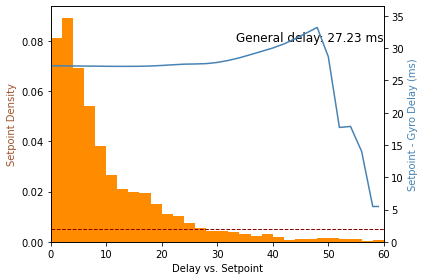

In [34]:
general_io_delay = np.sum(io_delay_filtered[0:9])/9
fig, ax1 = plt.subplots()
plt.xlim(0,io_bin_lenth*io_bins)
n, bins, patches = ax1.hist(sp_abs_mask, io_bins, density=True, color="darkorange")
ax1.set_xlabel('Delay vs. Setpoint')

ax1.set_ylabel('Setpoint Density', color="sienna")
plt.axhline(0.005 , color='darkred', linewidth=1, linestyle='--')

plt.text(60, 0.08, "General delay: %.2f ms"  %general_io_delay, size= 'large', ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Setpoint - Gyro Delay (ms)', color='steelblue')
ax2.set_ylim(0,max(spDelay)*1.05)
# we already handled the x-label with ax1
ax2.plot(io_delay_filtered_expa, color='steelblue')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

In [24]:

# Decode
os.system(decodeCommand)

# blackbox_decode will create a .event file, we don't need that
junkFile = logFileName+'.01.event'
os.remove(junkFile)
# Set the log file path
logFileName = 'delay'
logFileType = '.BBL'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

# Create decode command
decodeCommand = decodePath + ' ' + logFilePath
#print(cmd)

NameError: name 'decodeCommand' is not defined